# CSCE633 Machine Learning - HW2

## Programming Questions

### Part A - Classification Tree (50 points)

#### A-1 Data Processing and EDA

1. There are 2 data splits for this homework, data train and data test. The data test doesn’t have ground truth labels, you need to use the trained model to do inference on it. For validation, you can split the training data to train and validation sets. Read the data. (Try read csv() function in pandas library)

Put the data_train.csv and data_test.csv under the root directory or inside a data folder.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_data_path = "./data/data_train-1.csv"
test_data_path = "./data/data_test-1.csv"
out_path = "./Mu-Ruei_Tseng_preds.csv"

if not os.path.exists(train_data_path):
    train_data_path = "./data_train.csv"

if not os.path.exists(test_data_path):
    test_data_path = "./data_test.csv"
    
assert os.path.exists(train_data_path) and os.path.exists(test_data_path),"Data not found." 

print("Reading train data from: {}".format(train_data_path))
print("Reading test data from: {}".format(test_data_path))


Reading train data from: ./data/data_train-1.csv
Reading test data from: ./data/data_test-1.csv


2. Print the training data. How does the data look like? Add a short description about the data. (You may use head() function in pandas library)

In [2]:
train_df = pd.read_csv(train_data_path, index_col=0)
test_df = pd.read_csv(test_data_path, index_col=0)
num_rows = 5 # 
print("First {} rows of the training data: ".format(num_rows))
print(train_df.head(n=num_rows))

print("=================================================================================")

print("First {} rows of the test data: ".format(num_rows))
print(test_df.head(n=num_rows))


First 5 rows of the training data: 
    Loan_ID Gender Married Dependents Education Self_Employed  \
0  LP001518   Male     Yes          1  Graduate            No   
1  LP002734   Male     Yes          0  Graduate            No   
2  LP002697   Male      No          0  Graduate            No   
3  LP002455   Male     Yes          2  Graduate            No   
4  LP001732   Male     Yes          2  Graduate           NaN   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             1538             1425.0        30.0             360.0   
1             6133             3906.0       324.0             360.0   
2             4680             2087.0         NaN             360.0   
3             3859                0.0        96.0             360.0   
4             5000                0.0        72.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Urban           Y  
2       

Write-Up: TODO

3. Return the shape of the data. Shape means the dimensions of the data. (In Python, pandas dataframe instances have a variable shape)

In [3]:
print("The shape of the training dataframe: {}".format(train_df.shape))
print("=================================================================================")
print("The shape of the testing dataframe: {}".format(test_df.shape))

The shape of the training dataframe: (491, 13)
The shape of the testing dataframe: (123, 12)


4. Does the data have any missing values? How many are missing? Process the data to remove these missing values. You can drop the corresponding rows or apply imputation. (In pandas, check out isnull() and isnull().sum())

In [4]:
def check_missing_values(df):
    missing_values = [] # stores the row that contains missing(null) values
    total_missing_values = 0
    for index, row in df.iterrows():
        if row.isnull().any():
            missing_values.append(index)
        total_missing_values += row.isnull().sum()
    number_of_missing_values = len(missing_values)
    has_missing_values = True if number_of_missing_values > 0 else False
    
    return has_missing_values, number_of_missing_values, total_missing_values

print("Checking for missing values in the training data...")
has_missing_values, number_of_missing_values, total_missing_values = check_missing_values(train_df)
print("Does the data have any missing values? Ans:{}".format(has_missing_values))
print("How many rows have missing values? Ans:{}".format(number_of_missing_values))
print("Total number of missing values: {}".format(total_missing_values))
print("=================================================================================")

print("Checking missing values in the test data...")
has_missing_values, number_of_missing_values, total_missing_values = check_missing_values(test_df)
print("Does the data have any missing values? Ans:{}".format(has_missing_values))
print("How many rows have missing values? Ans:{}".format(number_of_missing_values))
print("Total number of missing values: {}".format(total_missing_values))
print("=================================================================================")

Checking for missing values in the training data...
Does the data have any missing values? Ans:True
How many rows have missing values? Ans:118
Total number of missing values: 129
Checking missing values in the test data...
Does the data have any missing values? Ans:True
How many rows have missing values? Ans:16
Total number of missing values: 20


If a data contains NaN values, we will drop that row.

In [5]:
train_df = train_df.dropna()
print("The shape of the training dataframe after dropping rows with any missing data: {}".format(train_df.shape))

test_df = test_df.dropna()
print("The shape of the test dataframe after dropping rows with any missing data: {}".format(test_df.shape))

The shape of the training dataframe after dropping rows with any missing data: (373, 13)
The shape of the test dataframe after dropping rows with any missing data: (107, 12)


5. Extract the features and the label from the data. Our label is Loan_Status in this case.

In [6]:
label_column = "Loan_Status"
feature_columns = [col for col in train_df.columns if col != label_column and col != "Loan_ID"]

features = train_df[feature_columns]
label = train_df[label_column]
num_features = features.shape[1]

print("Features: {}".format(features.shape))
print(features.head(n=num_rows))
print("=================================================================================")
print("Label: {}".format(label.shape))
print(label.head(n=num_rows))

Features: (373, 11)
  Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0   Male     Yes          1      Graduate            No             1538   
1   Male     Yes          0      Graduate            No             6133   
3   Male     Yes          2      Graduate            No             3859   
5   Male      No          0  Not Graduate           Yes             2583   
6   Male     Yes          0      Graduate            No             5829   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0             1425.0        30.0             360.0             1.0   
1             3906.0       324.0             360.0             1.0   
3                0.0        96.0             360.0             1.0   
5             2167.0       104.0             360.0             1.0   
6                0.0       138.0             360.0             1.0   

  Property_Area  
0         Urban  
1         Urban  
3     Semiurban  
5         Rural  
6         Ru

5. Plot the histograms of all the variables in the data.

In [7]:
def isCategorical(column_name):
    categorical_features = [
        'Loan_ID',
        'Gender',
        'Married',
        'Dependents',
        'Education',
        'Self_Employed',
        'Property_Area',
        'Loan_Status'
    ]
    return column_name in categorical_features

    
def plot_histogram(features):
    num_features = features.shape[1]
    feature_columns = features.columns
    
    plot_columns = 4
    plot_rows = num_features // plot_columns + (num_features % plot_columns > 0)
    fig, axes = plt.subplots(plot_rows, plot_columns, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i in range(num_features):
        ax = axes[i // plot_columns, i % plot_columns]
        is_categorical = isCategorical(feature_columns[i])
        
        if is_categorical:
            # For categorical data, use value_counts to get a bar chart
            category_counts = features.iloc[:, i].value_counts()
            ax.bar(category_counts.index, category_counts, width=0.5, edgecolor='black')
        else:
            # For numerical data, automatically determine the bin size
            bins = min(int(np.sqrt(features.iloc[:, i].shape[0])), 50)
            ax.hist(features.iloc[:, i], bins=bins, edgecolor='black')

        ax.set_title(feature_columns[i])

    # remove the empty subplots if the number of features is not a multiple of `plot_columns`
    for i in range(num_features, plot_rows * plot_columns):
        fig.delaxes(axes.flatten()[i])

    plt.suptitle("Histogram of the features", fontsize=16, y=1.02)
    fig.legend(["Histogram"], loc="lower right")

    plt.tight_layout()
    plt.show()

    return

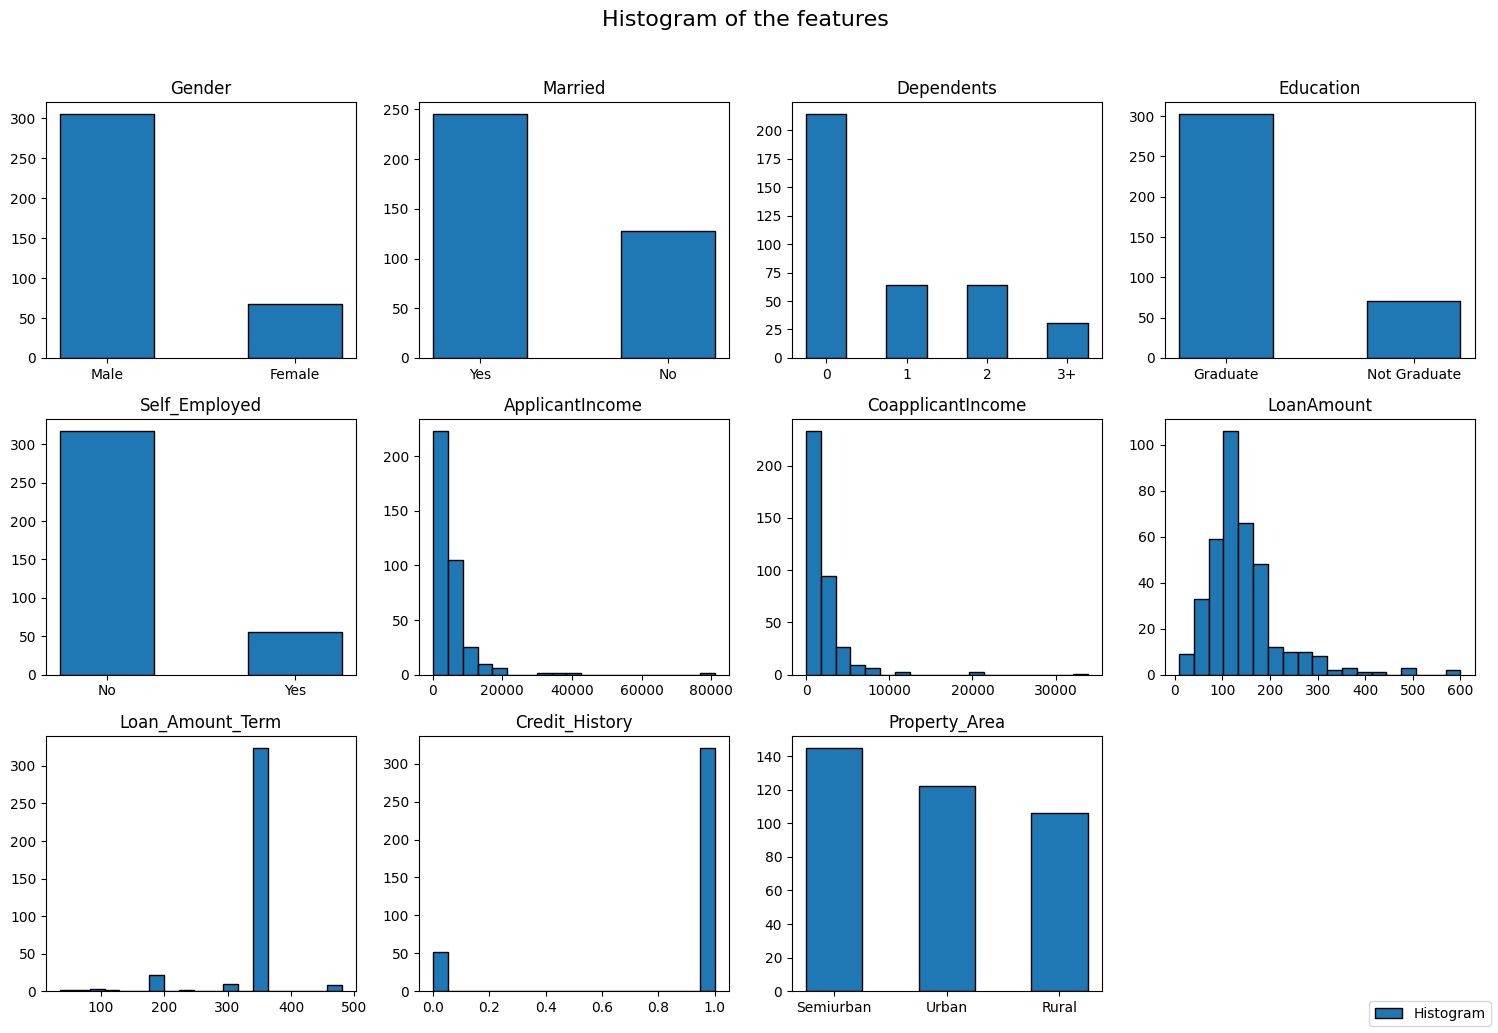

In [8]:
plot_histogram(features)

7. What are the different feature types in this data (e.g, continuous vs categorical).

In [9]:
columns = train_df.columns
continuous_features = []
categorical_features = []

for col in columns:
    if isCategorical(col):
        categorical_features.append(col)
    else:
        continuous_features.append(col)

print("Continuous Features: {}".format(continuous_features))
print("Categorical Features: {}".format(categorical_features))

Continuous Features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical Features: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


#### A-2 Implementation

Using the data you pre-processed above, implement a classification tree from scratch for prediction. You are NOT allowed to use machine learning libraries for the tree model. Build the tree model using training data and Gini Index as the splitting criteria. Validate the trained model with the validation data.

Below are the steps you may want to consider.
* Define a splitting criteria: 1) this criteria assigns a score to a split.
* Create the split: 1) split the dataset by iterating over all the rows and feature columns; 2) evaluate all the splits using the splitting criteria; 3) choose the best split.
* Build the tree: 1) decide when to stop growing (when the tree reaches the maximum allowed depth or when a leaf is empty or has only 1 element); 2) split recursively by calling the same splitting function; 3) create a root node and apply recursive splitting.
* Predict with the tree: For a given data point, make a prediction using the tree.

##### Dataset and Dataloader

I split the data into training and testing sets using a train-to-test ratio of 8:2.

In [10]:
def encode_features(features): 
    mapping = {}    
    for col in features.columns:
        if isCategorical(col):
            # One-hot encode the categorical features
            categories = features[col].unique()
            mapping[col] = {category: i for i, category in enumerate(categories)}
    
    return mapping

class Dataset:
    def __init__(self, features, label, ratio=0.8):
        self.features = features
        self.label = label
        self.mapping = encode_features(features)

        self.ratio = ratio
        self.num_samples = features.shape[0]
        self.num_train_samples = int(ratio * self.num_samples)
        self.num_test_samples = self.num_samples - self.num_train_samples
        
        self.train_indices = np.random.choice(self.num_samples, self.num_train_samples, replace=False)
        self.test_indices = np.array([i for i in range(self.num_samples) if i not in self.train_indices])

        print("Number of training samples: {}".format(self.num_train_samples))
        print("Number of test samples: {}".format(self.num_test_samples))
    
    def get_data(self, is_train=True):
        indices = self.train_indices if is_train else self.test_indices
        features = self.features.iloc[indices].copy()  # Explicitly working on a copy
        label = self.label.iloc[indices]

        for col in features.columns:
            if isCategorical(col):
                mapping = self.mapping[col]
                features.loc[:, col] = features.loc[:, col].apply(lambda x: mapping.get(x, x))
                features[col] = features[col].astype(int)
        # binarize the label
        label = label.apply(lambda x: 1 if x == "Y" else 0)

        return features, label

class DataLoader:
    def __init__(self, dataset):
        self.train_loader = dataset.get_data(is_train=True)
        self.test_loader = dataset.get_data(is_train=False)

In [11]:
dataset = Dataset(features, label)
dataloader = DataLoader(dataset)

train_data, train_label = dataloader.train_loader
val_data, val_label = dataloader.test_loader


Number of training samples: 298
Number of test samples: 75


In [12]:
class DecisionTree:
    class Node:
        def __init__(self, data, label, depth, classes):
            self.depth = depth
            self.data = data
            self.label = label
            self.classes = classes
            
            self.gini = self.giniIndex(label)

            self.split, (self.left_data, self.left_label), (self.right_data, self.right_label) = self.splitAttribute(data, label)
            self.value = [np.sum(label == l) for l in classes]

            self.left = None
            self.right = None
        
        def get_label(self):
            return self.classes[np.argmax(self.value)]

        def giniIndex(self, label):
            # calculate the gini index
            unique_labels = np.unique(label)
            gini = 1

            for l in unique_labels:
                gini -= (np.sum(label == l) / len(label)) ** 2

            return gini

        # use the gini index as the criterion
        def splitAttribute(self, data, label):
            min_impurity = np.inf   

            best_split = None
            for i in range(data.shape[1]):
                # for each feature, find the best split
                feature = data.iloc[:, i]
     
                unique_values = np.unique(feature)
                if unique_values.shape[0] > 1:
                    unique_values = (unique_values[1:] + unique_values[:-1]) / 2

                for v in unique_values:
                    left_data_indices = np.argwhere(data.iloc[:, i] <= v).flatten()
                    right_data_indices = np.argwhere(data.iloc[:, i] > v).flatten()

                    left_label = label.iloc[left_data_indices]
                    right_label = label.iloc[right_data_indices]

                    left_gini = self.giniIndex(left_label)
                    right_gini = self.giniIndex(right_label)

                    impurity = (left_gini * len(left_label) + right_gini * len(right_label)) / len(label)

                    if impurity < min_impurity:
                        min_impurity = impurity
                        best_split = (i, v)


            # Use boolean indexing for splitting
            split_value = best_split[1]
            left_mask = data.iloc[:, best_split[0]] <= split_value
            right_mask = ~left_mask

            left_data = data[left_mask]
            right_data = data[right_mask]
            left_label = label[left_mask]
            right_label = label[right_mask]

            return best_split, (left_data, left_label), (right_data, right_label)
        
        def __str__(self):
            if self.left is None and self.right is None:
                return "Node: depth={}, gini={:.3f}, samples={}, value=[{},{}]".format(self.depth, self.gini, self.label.shape[0], self.value[0], self.value[1])
            else:
                splitAttr = self.split[0]
                splitThreshold = self.split[1]
                return "Node: depth={}, x[{}]<={}, gini={:.3f}, samples={}, value=[{},{}]".format(self.depth, splitAttr, splitThreshold, self.gini, self.label.shape[0], self.value[0], self.value[1])

    def __init__(self, max_depth=3):
        self.max_depth = max_depth 
        self.tree = None


    def generateTree(self, data, label, depth):
        node = self.Node(data, label, depth, self.classes)
        
        if depth >= self.max_depth or data.shape[0] < 2 or data.shape[1] == 0 or np.unique(label).shape[0] == 1:
            return node

        node.left = self.generateTree(node.left_data, node.left_label, depth + 1)
        node.right = self.generateTree(node.right_data, node.right_label, depth + 1)

        return node


    def fit(self, X, y):        
        self.classes = np.unique(y)
        self.root = self.generateTree(X, y, 0)
    
    def plot(self, node):
        if node is not None:
            print(node)
            self.plot(node.left)
            self.plot(node.right)

    def plot_tree(self):
        self.plot(self.root)

    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            y_pred.append(self._predict(self.root, X.iloc[i]))
        return y_pred

    def _predict(self, node, X):
        if node.left is None and node.right is None:
            return node.get_label()
        
        if X[node.split[0]] <= node.split[1]:
            return self._predict(node.left, X)
        else:
            return self._predict(node.right, X)
        

            


##### Train the decision tree

In [13]:
max_depth = 5
clf = DecisionTree(max_depth=max_depth)
clf.fit(train_data, train_label)
clf.plot_tree()


Node: depth=0, x[9]<=0.5, gini=0.427, samples=298, value=[92,206]
Node: depth=1, x[5]<=4316.5, gini=0.210, samples=42, value=[37,5]
Node: depth=2, x[8]<=240.0, gini=0.077, samples=25, value=[24,1]
Node: depth=3, x[3]<=0.5, gini=0.375, samples=4, value=[3,1]
Node: depth=4, gini=0.000, samples=1, value=[0,1]
Node: depth=4, gini=0.000, samples=3, value=[3,0]
Node: depth=3, gini=0.000, samples=21, value=[21,0]
Node: depth=2, x[5]<=5392.5, gini=0.360, samples=17, value=[13,4]
Node: depth=3, x[0]<=0.5, gini=0.444, samples=6, value=[2,4]
Node: depth=4, gini=0.000, samples=4, value=[0,4]
Node: depth=4, gini=0.000, samples=2, value=[2,0]
Node: depth=3, gini=0.000, samples=11, value=[11,0]
Node: depth=1, x[8]<=420.0, gini=0.337, samples=256, value=[55,201]
Node: depth=2, x[8]<=48.0, gini=0.327, samples=253, value=[52,201]
Node: depth=3, gini=0.000, samples=2, value=[2,0]
Node: depth=3, x[5]<=1704.5, gini=0.319, samples=251, value=[50,201]
Node: depth=4, x[6]<=1653.0, gini=0.480, samples=5, value

##### Validate the model

In [14]:
y_pred = clf.predict(val_data)
accuracy = np.sum(y_pred == val_label) / len(val_label)

print("Accuracy: ", accuracy)

Accuracy:  0.7733333333333333


##### Verify the result with sklearn

Accuracy: 0.7733333333333333
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        14
           1       0.95      0.98      0.97        61

    accuracy                           0.95        75
   macro avg       0.93      0.88      0.91        75
weighted avg       0.95      0.95      0.95        75



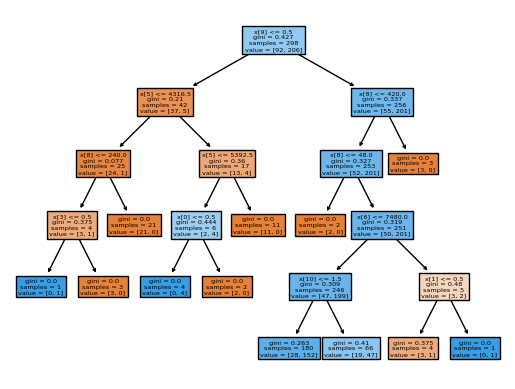

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


clf_sklearn = DecisionTreeClassifier(max_depth=max_depth)
# Train Decision Tree Classifer
clf_sklearn.fit(train_data, train_label)
# Visualize the decision tree
tree.plot_tree(clf_sklearn, filled=True)
#Predict the response for test dataset
y_pred_sklearn = clf_sklearn.predict(val_data)
print("Accuracy:", np.sum(y_pred_sklearn == val_label) / len(val_label))

# calculate the precision, recall, and f1-score between the predicted label from the sklearn model and my model
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_pred_sklearn))



##### Inference on test data

Using the trained model, conduct inference on the test data and save the predicted result in a separate file called FirstName LastName preds.csv with the column name pred tree.

In [16]:
test_data = test_df[feature_columns].copy()
for col in test_data.columns:
    if isCategorical(col):
        mapping = dataset.mapping[col]
        test_data.loc[:, col] = test_data.loc[:, col].apply(lambda x: mapping.get(x, x))
        test_data[col] = test_data[col].astype(int)

y_pred = clf.predict(test_data)
# convert the label back to the original format
y_pred = ["Y" if y == 1 else "N" for y in y_pred]

if not os.path.exists(out_path):
    print("Creating a new predictions dataframe")
    predictions_df = pd.DataFrame(columns=["pred_tree", "pred_xgboost"])
else:
    print("Reading the existing predictions from: {}".format(out_path))
    predictions_df = pd.read_csv(out_path)

predictions_df["pred_tree"] = y_pred
print(predictions_df.head(n=5))

print("Saving the predictions to: {}".format(out_path))
predictions_df.to_csv(out_path, index=False)


Reading the existing predictions from: ./Mu-Ruei_Tseng_preds.csv
  pred_tree pred_xgboost
0         Y            Y
1         Y            Y
2         Y            Y
3         N            N
4         Y            Y
Saving the predictions to: ./Mu-Ruei_Tseng_preds.csv


### Part B - Boosting (30 points)

Now that we implemented classification trees in part A, we would like to use a decision tree-based ensemble Machine Learning algorithm for Loan Dataset. You can use the same pre-processed dataset as part A.


Define a function train_XGBoost to use an XGBoost model with L2 regularization that returns a dictionary. The keys of the returned dictionary would be the lambda parameter (for L2 regularization) and the corresponding value is the mean AUC of 10 fold cross validation. Use the following lambda parameters: [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]. Describe the process of finding the optimal lambda value for l2 regularization.

In [17]:
import xgboost
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve

def train_XGBoost(train_data, train_label, verbose=True):
    
    lamda_params = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
    result = {}
    num_folds = 10
    fold_size = train_data.shape[0] // num_folds

    for lamda in lamda_params:
        print("Training with lambda={}".format(lamda))
        # 10-fold cross-validation
        aucs = []
        for i in range(num_folds):
            if verbose:
                print("Fold: ", i)
            val_indices = np.arange(i * fold_size, (i + 1) * fold_size)
            train_indices = np.array([j for j in range(train_data.shape[0]) if j not in val_indices])

            _val_data = train_data.iloc[val_indices]
            _val_label = train_label.iloc[val_indices]

            _train_data = train_data.iloc[train_indices]
            _train_label = train_label.iloc[train_indices]

            model = xgboost.XGBClassifier(reg_lambda=lamda)
            model.fit(_train_data, _train_label)

            y_pred = model.predict(_val_data)
            auc = roc_auc_score(_val_label, y_pred)
            accuracy = np.sum(y_pred == _val_label) / len(_val_label)
            precision = precision_score(_val_label, y_pred)
            recall = recall_score(_val_label, y_pred)
            f1 = f1_score(_val_label, y_pred)
            aucs.append(auc)
            if verbose:
                print(" - AUC: {:.3f}, Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 score: {:.3f}".format(auc, accuracy, precision, recall, f1))
        aucs = np.array(aucs)
        result[lamda] = aucs.mean()

    return result
    

In [18]:
result = train_XGBoost(train_data, train_label, verbose=False)

Training with lambda=0.001
Training with lambda=0.01
Training with lambda=0.1
Training with lambda=1
Training with lambda=10.0
Training with lambda=100.0
Training with lambda=1000.0


In [19]:
best_lamda = max(result, key=result.get)
print("Best lambda: ", best_lamda, "AUC: ", result[best_lamda])

Best lambda:  100.0 AUC:  0.667437682931104


Train and test the model with the best parameters you found.

In [20]:
model = xgboost.XGBClassifier(reg_lambda=best_lamda)
model.fit(train_data, train_label)
model.predict(val_data)

y_pred = model.predict(val_data)
auc = roc_auc_score(val_label, y_pred)
accuracy = np.sum(y_pred == val_label) / len(val_label)
precision = precision_score(val_label, y_pred)
recall = recall_score(val_label, y_pred)
f1 = f1_score(val_label, y_pred)
print("AUC: {:.3f}, Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 score: {:.3f}".format(auc, accuracy, precision, recall, f1))

AUC: 0.700, Accuracy: 0.800, Precision: 0.769, Recall: 1.000, F1 score: 0.870


Plot the ROC curve for the XGBoost model on validation data and also print the area under the curve. Include axes labels, legend, and title in the Plot.

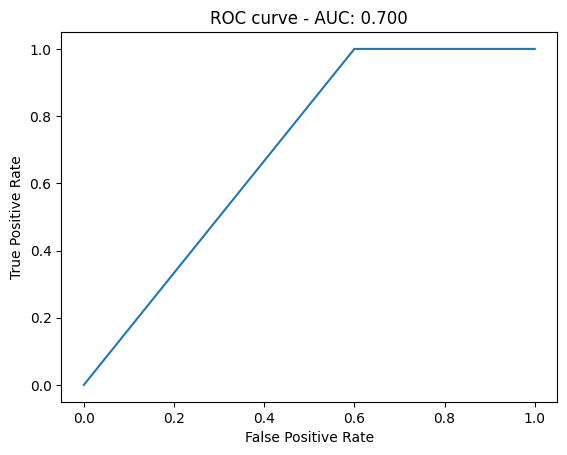

In [21]:
# plot the ROC curve
fpr, tpr, thresholds = roc_curve(val_label, y_pred)
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - AUC: {:.3f}'.format(auc))
plt.show()

Compare the validation result you obtained using XGBoost with the results using the tree you implemented in part A. Which model did perform better and why?

In [22]:
# TODO

##### Inference on test data

Using the trained model, conduct inference on the test data and save the predicted result into the predictions csv file with pred xgboost as the column name.

In [23]:
y_pred = model.predict(test_data)
# convert the label back to the original format
y_pred = ["Y" if y == 1 else "N" for y in y_pred]

if not os.path.exists(out_path):
    print("Creating a new predictions dataframe")
    predictions_df = pd.DataFrame(columns=["pred_tree", "pred_xgboost"])
else:
    print("Reading the existing predictions from: {}".format(out_path))
    predictions_df = pd.read_csv(out_path)

predictions_df["pred_xgboost"] = y_pred
print(predictions_df.head(n=5))

print("Saving the predictions to: {}".format(out_path))
predictions_df.to_csv(out_path, index=False)


Reading the existing predictions from: ./Mu-Ruei_Tseng_preds.csv
  pred_tree pred_xgboost
0         Y            Y
1         Y            Y
2         Y            Y
3         N            N
4         Y            Y
Saving the predictions to: ./Mu-Ruei_Tseng_preds.csv
